# Lab 07

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 2: Read data

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the `load_data` function according to the following guidelines:
- to read label and image names: use the os library (in particular the os.listdir() and os.path.join() methods)
- to load an image: use the load_image() method (see list of imported libraries)
- to transform images to arrays: use the img_to_array() method (see list of imported libraries)

In [3]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    # FILL IN CODE HERE #

    images = np.full((27000, 64, 64, 3), np.empty([64, 64, 3]))  
    labels = [""] * 27000

    classes_arr = os.listdir(DATA_PATH)
    classes_arr.remove('.DS_Store')
    i = 0
    
    for class_label in classes_arr:
        curr_label = class_label

        class_dir = os.path.join(DATA_PATH, curr_label)
        for image in os.listdir(class_dir):
            img_path = os.path.join(DATA_PATH, curr_label, image)
            images[i] = tf.keras.utils.img_to_array(tf.keras.utils.load_img(img_path))
            labels[i] = curr_label
            i += 1
            
    labels = np.array(labels)
    return images, labels

In [6]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 3: Inspect data

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

In [9]:
import collections
collections.Counter(labels)

Counter({'Forest': 3000,
         'AnnualCrop': 3000,
         'SeaLake': 3000,
         'HerbaceousVegetation': 3000,
         'Residential': 3000,
         'River': 2500,
         'Highway': 2500,
         'Industrial': 2500,
         'PermanentCrop': 2500,
         'Pasture': 2000})

<Axes: xlabel='Class', ylabel='Frequency'>

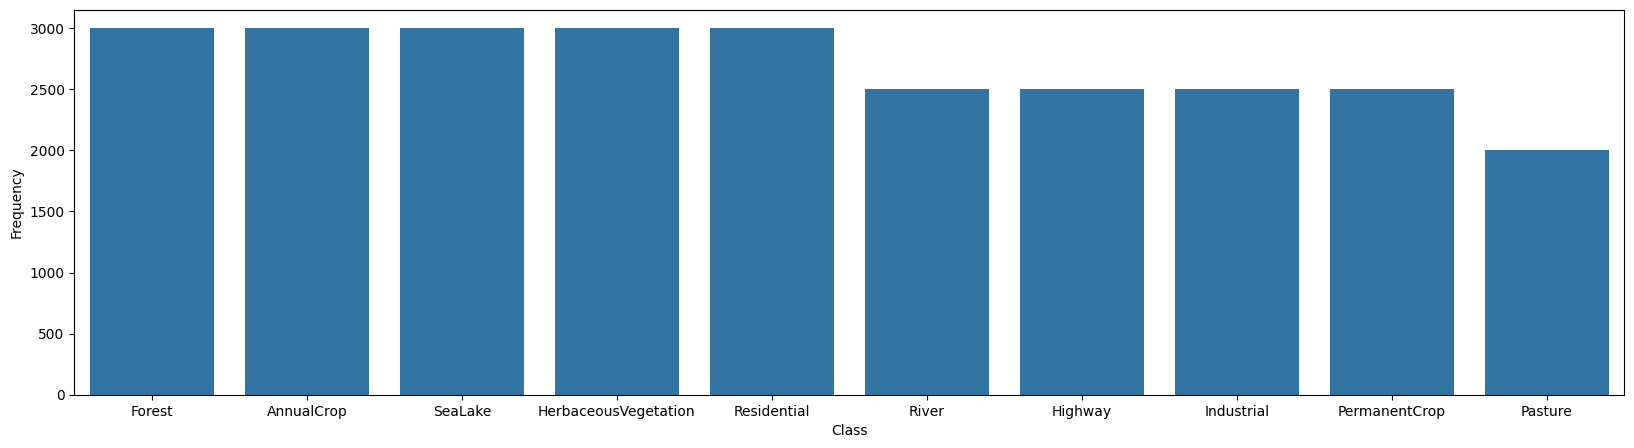

In [7]:
ax_dims = (20, 5)
fig, ax = plt.subplots(figsize=ax_dims)
classesAndFrequencies = pd.DataFrame({"Class": ['Forest', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Residential', 'River', 'Highway', 'Industrial', 'PermanentCrop', 'Pasture'], 
'Frequency': [3000, 3000, 3000, 3000, 3000, 2500, 2500, 2500, 2500, 2000]})
sns.barplot(ax=ax, data=classesAndFrequencies, x = 'Class', y = 'Frequency')

Comment on class balance: The classes appear more-or-less balanced since all classes have within 2000-3000 images each. Although there are 1000 more Forest images than there are for Pasture images, this difference should not be a problem.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

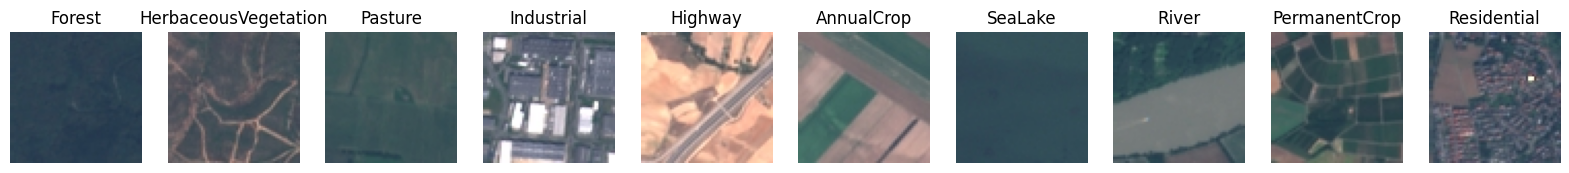

In [8]:
# FILL IN CODE HERE #
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
i = 0
for classLabel in set(labels):
    classImages = os.listdir(os.path.join(DATA_PATH, classLabel))
    axs[i].imshow(tf.keras.utils.load_img(os.path.join(DATA_PATH, classLabel, classImages[0])), cmap='gray')
    axs[i].set_title(classLabel)
    axs[i].axis('off')
    i += 1

plt.show()

Most confused land classes: The Forest, SeaLake, and Pasture classes seem mostly likely to be confused with each other since their images consist of almost a solid dark backdrop with little distinguishing features as far as the eye can see.

---
### Step 4: Preprocess data

Encode labels

In [9]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the `split_data` function according to the following guidelines:
- shuffle images and labels before spliting the data
- use a 60/20/20 split

In [11]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    n = images.shape[0]
    indices = np.arange(n)
    shuffled_indices = np.random.permutation(indices)
    images = images[shuffled_indices]
    labels = labels[shuffled_indices]

    
    # create data splits
    # FILL IN CODE HERE #

    train, valid, test = split
    train_end = int(train * n)
    valid_end = int(n * (train + valid))
    X_train, y_train = images[:train_end], labels[:train_end]
    X_val, y_val = images[train_end:valid_end], labels[train_end:valid_end]
    X_test, y_test = images[valid_end:], labels[valid_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
# Define splits
split = (0.6, 0.2, 0.2)

# Create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the `data_preprocessing()` function according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module).
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels.
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [13]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test data;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = X + DELTA

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.random_flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X = X / 255.0
    
    return X, y

Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): It is important to add augmented images to the training data so that our machine learning model can generalize well to new data, which can often take the form of variations to similar images already in the training set. We do not add augmented images to the validation and test data since these forms of data are supposed to represent untouched, unseen data. Adding artificial images to our evaluation data would defeat the purpose of new data being unaltered and coming from the real world.

In [14]:
# Apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [15]:
# Compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# Reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# Print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the RandomForestClassifier class available in the sklearn.ensemble module
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [16]:
# Train the Model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=2, n_jobs=1, max_depth=8, random_state=7)
clf.fit(X_train_re, y_train)

RandomForestClassifier(max_depth=8, n_estimators=2, n_jobs=1, random_state=7)

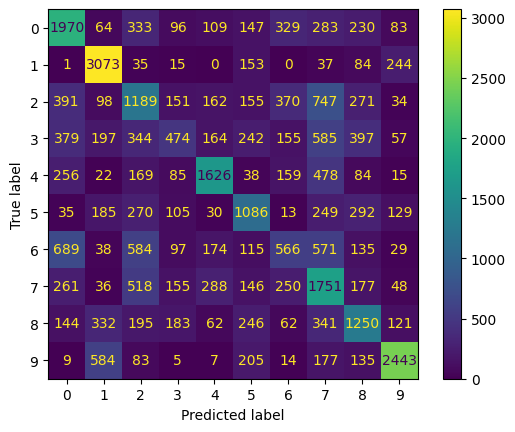

In [17]:
# Make Predictions for Training Set and Display Confusion Matrix
y_train_pred = clf.predict(X_train_re)
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_train).plot()

In [18]:
# Compute Accuracy of Model on Training Data

np.sum(y_train_pred == y_train) / len(y_train_pred)

0.47617283950617284

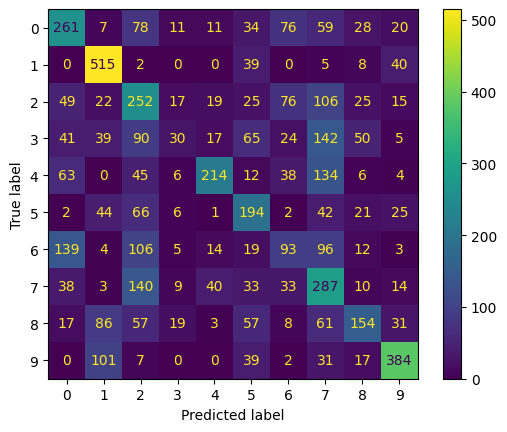

In [19]:
# Make Predictions for Validation Set and Display Confusion Matrix
y_val_pred = clf.predict(X_val_re)
cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val).plot()

In [20]:
# Compute Accuracy of Model on Validation Data

np.sum(y_val_pred == y_val) / len(y_val_pred)

0.4414814814814815

Comment on model accuracy on training vs. validation data: The model has an accuracy of about 0.48 on the training dataset, while the model has an accuracy of about 0.44 on the validation dataset.

Does the model generalize well?: Since the model has an accuracy of about 0.48 on the training dataset and an accuracy of about 0.44 on the validation dataset, the model performs poorly and does not generalize well.

Comment on the classes that the model confuses the most: For the training set, the model confuses AnnualCrop with PermanentCrop the most. The model confuses Forest with SeaLake the most. The model confuses HerbaceousVegetation with PermanentCrop the most. The model confuses Highway with River the most. The model confuses Industrial with Residential the most. The model confuses Pasture with River the most. The model confuses Residential with HerbaceousVegetation the most. These confusions are also reflected in the validation data. 

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). The model should also generalize well (the performance difference between the training and validation sets should be at most 10%). Also, be sure to follow these guidelines: 
    
- Use the RandomForestClassifier or the GradientBoostingClassifier available in the sklearn.ensemble module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Does your model generalize well?
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [103]:
rf_clf2 = RandomForestClassifier(n_estimators=18, n_jobs=1, max_depth=8, random_state=7)
### YOUR CODE HERE ###

rf_clf2.fit(X_train_re, y_train)

RandomForestClassifier(max_depth=8, n_estimators=18, n_jobs=1, random_state=7)

In [104]:
y_train_pred = rf_clf2.predict(X_train_re)

In [105]:
np.sum(y_train_pred == y_train) / len(y_train_pred)

0.6103703703703703

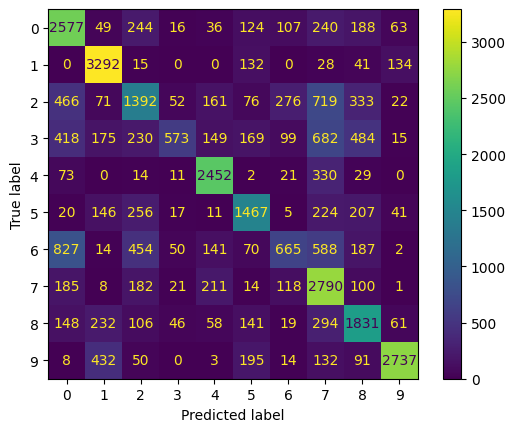

In [108]:
cm_new_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_new_train).plot()

In [106]:
y_val_pred = rf_clf2.predict(X_val_re)

In [107]:
np.sum(y_val_pred == y_val) / len(y_val_pred)

0.5351851851851852

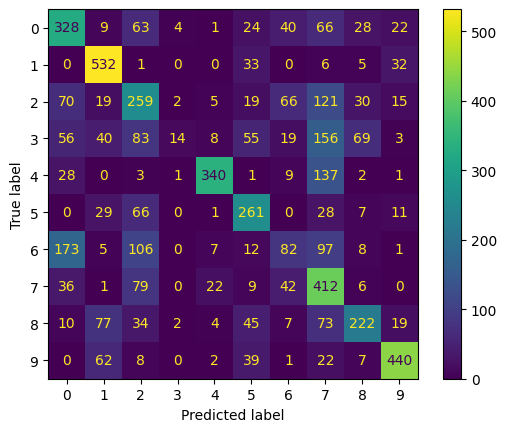

In [109]:
cm_new_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_new_val).plot()

15, 8

How your implementation is different compared to the baseline classifier: Compareed to the baseline classifier, the model has 18 estimators instead of only 2 estimators.

Comment on training vs. validation performance relative to baseline model: The training accuracy of the new model is 0.610, while the training accuracy of the baseline model was 0.476.  The validation accuracy of the new model is 0.535, while the validation accuracy of the baseline model was 0.441.

Does the model generalize well? Relative to the baseline model, the model generalizes well since the validation accuracy has improved to 0.535. Moreover, the difference in training accuracy and validation accuracy is close to 10%.

Comment on the classes the model confuses the most relative to the baseline: For AnnualCrop images, the new model confuses PermanentCrop images the most. For Forest images, the new model confuses SeaLake images the most. Likewise for SeaLake images, the new model confuses Forest images the most. For HerbaceousVegetation images, the new model confuses PermanentCrop images the most. For Highway images, the new model confuses HerbaceousVegetation images the most. For Industrial images, the new model confuses Residential images the most. For Pasture images, the new model confuses SeaLake images the most. For PermanentCrop images, the new model confuses HerbaceousVegetation the most. For Residential images, the new model confuses HerbaceousVegetation images the most. For River images, the new model confuses Highway images the most. Most of these confusions are similar to those made by the baseline model.

---
### Step 6: Evaluation (on test data)

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the validation set?

In [111]:
y_test_pred = rf_clf2.predict(X_test_re)

In [112]:
np.sum(y_test_pred == y_test) / len(y_test_pred)

0.524074074074074

Comment on test set accuracy vs. validation set accuracy: The test set accuracy is 0.524, while the validation set accuracy is 0.535. There is only a slight difference between the two accuracies.

---
### Step 7: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

Yes, I would recommend a Decision Forest for land cover classification since it can mitigate issues with overfitting and can lead to higher validation and test accuracies. The new RandomForest classifier implemented in the last exercise has shown to increase the validation accuracy by more than 10%.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

Neural networks are another great ML model for improving performance of land cover classification. Specifically, Convolutional Neural Networks are a suitable model for this task since layers of the network can identify outlines or distinguishing features of visual data to help yield better classification results.

#### <span style="color:chocolate"> Bonus Exercise (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [ ]:
### YOUR CODE HERE ###